# NFL Covariates
Notebook contains code to extract demographic, performance, team, and city-based features. Used by the notebook `nba-sentiment.ipynb` for regression.

In [1]:
import pandas as pd
import string
import numpy as np
%matplotlib inline

In [2]:
city_mapping = {'ARI':'PHO', 'CAR':'CHO', 'GNB':'GB', 'JAX':'JAC', 'KAN':'KC', 'LACH':'LAC', 'LARM':'LAR',
                'NE':'BOS', 'NWE':'BOS', 'NOR':'NOP', 'NO':'NOP', 'SD':'SDG','SFO':'SF', 'TAM':'TB',
                'New England Patriots': 'BOS', 'Miami Dolphins': 'MIA', 'New York Jets': 'NYJ', 'Buffalo Bills': 'BUF',
                'Baltimore Ravens': 'BAL', 'Cincinnati Bengals': 'CIN', 'Pittsburgh Steelers': 'PIT', 'Cleveland Browns': 'CLE',
                'Houston Texans': 'HOU', 'Indianapolis Colts': 'IND', 'Tennessee Titans': 'TEN', 'Jacksonville Jaguars': 'JAC',
                'Denver Broncos': 'DEN', 'San Diego Chargers': 'SDG', 'Oakland Raiders': 'OAK', 'Kansas City Chiefs': 'KC',
                'Washington Redskins': 'WAS', 'New York Giants': 'NYG', 'Dallas Cowboys': 'DAL', 'Arizona Cardinals': 'PHO',
                'Philadelphia Eagles': 'PHI', 'Green Bay Packers': 'GB', 'Minnesota Vikings': 'MIN',
                'Chicago Bears': 'CHI', 'Detroit Lions': 'DET', 'Atlanta Falcons': 'ATL', 'Carolina Panthers': 'CHO',
                'New Orleans Saints': 'NOP', 'Tampa Bay Buccaneers': 'TB', 'San Francisco 49ers': 'SF', 'Seattle Seahawks': 'SEA',
                'St. Louis Rams': 'STL', 'Los Angeles Chargers': 'LAC', 'Los Angeles Rams': 'LAR' }

## 1. Load player demographic and performance data
### Demographics
#### Ethnicity
To get a list of black players, I queried Wikipedia's Categories for African American football players and Samon players. This list contained a large fraction of players, but did not label all players, nor identify white NFL players. I then supplemented this list by Googling the ethnicity of the remaining players

In [2]:
nonwiki_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_players_race_unknown.csv')

In [3]:
race_nfl_df = pd.concat([pd.read_csv('d:/data/sentiment_sports/covariates/nfl_race_players.tsv', sep='\t'),
                        nonwiki_df])

#### Download demographics of recent players with weight, height, etc.
`pro-football-reference.com` has non-racial demographic data for players going back to the fifties. Here I download those players' data, and filter to recent players.

In [3]:
demo_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_players2010-2018.tsv', sep ='\t', encoding = 'utf-8')
demo_df['Player'] = demo_df['Player'].str.lower()
demo_df['position'] = demo_df['position'].str.strip('()').str.lower().str.split('-').str[0]
def map_name(name):
    if '.' in name:
        return name.replace('.', ' ').replace('  ', ' ') # <- janky
    return name.split(' ')[0][0] + ' ' + name.split(' ')[1]
demo_df['player_join'] = demo_df['Player'].apply(map_name)

In [10]:
# have to manually fix some player name mappings
player_map = {'ej manuel':'ej manuel',
                         'marlon brown': 'ma brown',  'mike brown': 'mi brown', 'john brown': 'jo brown',
                         'deangelo williams': 'de williams', 'david johnson':'da johnson',
                         'trent taylor':'tr taylor', 'jj nelson': 'j j nelson',
                         'jaron brown':'ja brown', "nick o\\'leary": "n o'leary"
                         }
demo_df['player_join'] = demo_df.apply(lambda row: player_map[row['Player']] if row['Player'] in player_map else row['player_join'], axis=1)
position_map = {'fb':'rb'}
demo_df['position'] = demo_df['position'].replace(position_map)
demo_df['Tm'] = demo_df['Tm'].replace(city_mapping)

#### Player performance
For player performance, I download data from `footballoutsiders.com`

In [11]:
#performance_df.to_csv('d:/data/sentiment_sports/nfl_stats_2012-2017.tsv', sep='\t', index = False)
performance_df = (pd.read_csv('d:/data/sentiment_sports/nfl_stats_2012-2017.tsv', sep='\t')
                    .rename(columns={'Team':'Tm'}))
performance_df['player_join'] = performance_df['Player'].str.replace('.', ' ').str.lower()

In [12]:
performance_df['Tm'] = performance_df['Tm'].replace(city_mapping)

#### Team info
Here I download team performance from `pro-football-outsiders.com`

In [13]:
#team_df.to_csv('d:/data/sentiment_sports/covariates/nfl_teams_2012-2018.tsv', sep='\t', index=False)
team_df= (pd.read_csv('d:/data/sentiment_sports/covariates/nfl_teams_2012-2018.tsv', sep='\t')
            .rename(columns = {'W':'Wins'}))[['Tm', 'Wins', 'year']]

In [16]:
team_df['Tm'] = team_df['Tm'].str.strip(string.punctuation)
team_df['Tm'] = team_df['Tm'].replace(city_mapping)

#### Salary

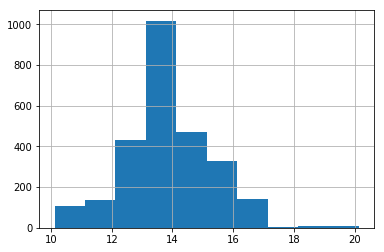

In [19]:
np.log(salary_df['salary']).hist();

In [18]:
salary_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_salary.tsv', sep='\t')

#### City demographics
When thinking about race, we considered whether the demographics of the city influence player popularity. I downloaded census and polling data for NFL cities.

In [20]:
# city demographics
city_df = pd.read_csv('d:/data/sentiment_sports/covariates/sports_metro_demographics.csv').drop(columns = ['census_Id', 'census_Id2', 'Geography'])

In [21]:
vote_df = pd.read_csv('d:/data/sentiment_sports/covariates/msa_votes.tsv', sep='\t')[['per_point_diff', 'Tm']].rename(columns={'per_point_diff':'clinton_vote_lead'})

### Combine info
After getting all of the data for various covariates, I combine them into a single dataframe that has performance, demographics, and city information.

In [22]:
covariates_df = (performance_df.merge(demo_df, on = ['player_join', 'position', 'Tm', 'year'], how='left', suffixes=('_FO', ''))
                             .merge(race_nfl_df, on='Player', how='left')
                             .merge(salary_df, on=['Player', 'year'], how='left')
                      .merge(team_df, on=['Tm', 'year'], how ='left')
                      .merge(city_df, on='Tm', how='left')
                      .merge(vote_df, on='Tm', how='left')
                      .dropna(subset= ['start_year'])
                )
covariates_df['experience'] = covariates_df['year'] - covariates_df['start_year']
covariates_df.head(2)

,Player_FO,Tm,position,DYAR,DVOA,TD,z_DYAR,z_DVOA,z_TD,year,...,birth_date,race,salary,standard_salary,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
0,T.Brady,BOS,qb,2035,35.1,34,2.574492,1.846341,1.437475,2012,...,"August 3, 1977",W,NaN,NaN,12.0,4728844.0,77.3,8.0,0.3815,12.0
1,P.Manning,DEN,qb,1805,32.8,37,2.222644,1.738123,1.722051,2012,...,"March 24, 1976",W,NaN,NaN,13.0,2752056.0,81.9,5.6,0.5638,14.0


In [23]:
covariates_df.to_csv('d:/data/sentiment_sports/covariates/nfl_player_covariates.tsv', sep='\t', index = False)